In [1]:
%matplotlib inline


Analysis of a single session, single subject fMRI dataset
=========================================================

In this tutorial, we compare the fMRI signal during periods of auditory
stimulation versus periods of rest, using a General Linear Model (GLM).

The dataset comes from an experiment conducted at the FIL by Geriant Rees
under the direction of Karl Friston. It is provided by FIL methods
group which develops the SPM software.

According to SPM documentation, 96 scans were acquired (repetition time TR=7s) in one session. The paradigm consisted of alternating periods of stimulation and rest, lasting 42s each (that is, for 6 scans). The sesssion started with a rest block.
Auditory stimulation consisted of bi-syllabic words presented binaurally at a
rate of 60 per minute. The functional data starts at scan number 4, that is the 
image file ``fM00223_004``.

The whole brain BOLD/EPI images were acquired on a  2T Siemens
MAGNETOM Vision system. Each scan consisted of 64 contiguous
slices (64x64x64 3mm x 3mm x 3mm voxels). Acquisition of one scan took 6.05s, with the scan to scan repeat time (TR) set arbitrarily to 7s.

The analyse described here is performed in the native space, directly on the
original EPI scans without any spatial or temporal preprocessing.
(More sensitive results would likely be obtained on the corrected,
spatially normalized and smoothed images).


To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use ``jupyter-notebook``.
    :depth: 1




Retrieving the data
-------------------

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we load the data using a data downloading
          function. To input your own data, you will need to provide
          a list of paths to your own files in the ``subject_data`` variable.
          These should abide to the Brain Imaging Data Structure (BIDS) 
          organization.</p></div>



In [2]:
from nistats.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()
print(subject_data.func)  # print the list of names of functional images

['/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img', '/home/users/zenkavi/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img', '/home/users/zenkavi/nilearn_data/spm_a

We can display the first functional image and the subject's anatomy:



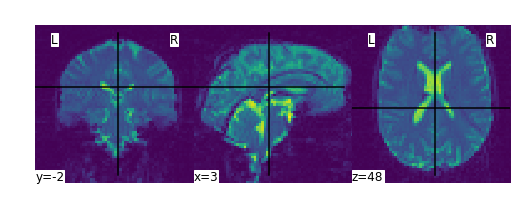

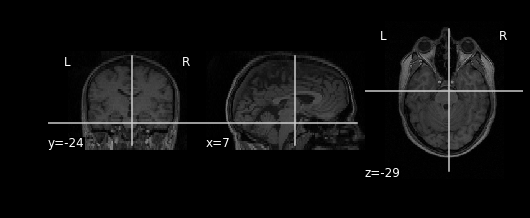

In [3]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
plot_img(subject_data.func[0])
plot_anat(subject_data.anat)

Next, we concatenate all the 3D EPI image into a single 4D image,
then we average them in order to create a background
image that will be used to display the activations:



In [4]:
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

Specifying the experimental paradigm
------------------------------------

We must now provide a description of the experiment, that is, define the
timing of the auditory stimulation and rest periods. This is typically
provided in an events.tsv file. The path of this file is
provided in the dataset.



In [5]:
import pandas as pd
events = pd.read_table(subject_data['events'])
print(events)

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


    onset  duration trial_type
0     0.0      42.0       rest
1    42.0      42.0     active
2    84.0      42.0       rest
3   126.0      42.0     active
4   168.0      42.0       rest
5   210.0      42.0     active
6   252.0      42.0       rest
7   294.0      42.0     active
8   336.0      42.0       rest
9   378.0      42.0     active
10  420.0      42.0       rest
11  462.0      42.0     active
12  504.0      42.0       rest
13  546.0      42.0     active
14  588.0      42.0       rest
15  630.0      42.0     active


Performing the GLM analysis
---------------------------

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix* using the  information provided by the ``events`` object.



In [6]:
from nistats.first_level_model import FirstLevelModel

Parameters of the first-level model

* t_r=7(s) is the time of repetition of acquisitions
* noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
* standardize=False means that we do not want to rescale the time
series to mean 0, variance 1
* hrf_model='spm' means that we rely on the SPM "canonical hrf"
model (without time or dispersion derivatives)
* drift_model='cosine' means that we model the signal drifts as slow oscillating time functions
* period_cut=160(s) defines the cutoff frequency (its inverse actually).



In [7]:
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           period_cut=160)

Now that we have specified the model, we can run it on the fMRI image



In [8]:
fmri_glm = fmri_glm.fit(fmri_img, events)

One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [9]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is
implictily meant to for multiple runs.



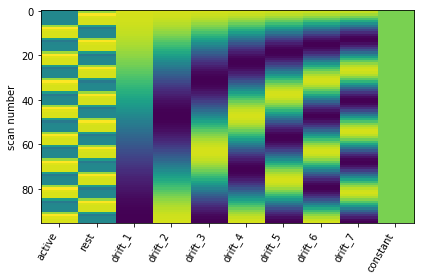

In [10]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Save the design matrix image to disk
first create a directory where you want to write the images



In [11]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

The first column contains the expected reponse profile of regions which are
sensitive to the auditory stimulation.
Let's plot this first column



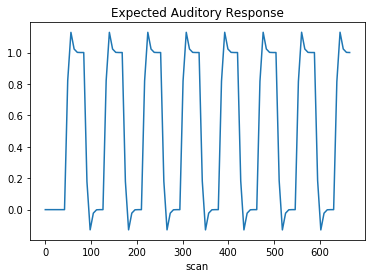

In [12]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we
created constrast with a single '1' in each of the columns: The role
of the contrast is to select some columns of the model --and
potentially weight them-- to study the associated statistics. So in
a nutshell, a contrast is a weigted combination of the estimated
effects.  Here we can define canonical contrasts that just consider
the two condition in isolation ---let's call them "conditions"---
then a contrast that makes the difference between these conditions.



In [13]:
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

We can then compare the two conditions 'active' and 'rest' by
defining the corresponding contrast:



In [14]:
active_minus_rest = conditions['active'] - conditions['rest']

Let's look at it: plot the coefficients of the contrast, indexed by
the names of the columns of the design matrix.



/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


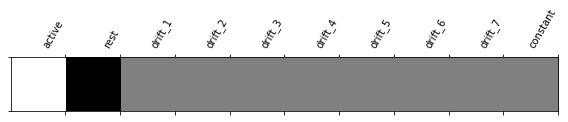

In [15]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

Below, we compute the estimated effect. It is in BOLD signal unit,
but has no statistical guarantees, because it does not take into
account the associated variance.



In [126]:
eff_map = fmri_glm.compute_contrast(conditions['active'],
                                    output_type='effect_size')

In [127]:
var_map = fmri_glm.compute_contrast(conditions['active'],
                                    output_type='effect_variance')

In [128]:
sd_map = np.sqrt(var_map.get_fdata())

In [129]:
beta_map = eff_map.get_fdata()*sd_map

In [130]:
np.where(beta_map == np.amax(beta_map))

(array([30]), array([13]), array([23]))

In [182]:
tmp1 = nibabel.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/fsl/level_1/sub-311444/model1/run-001.feat/stats/cope1.nii.gz')

In [192]:
tmp1a = nibabel.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/fsl/level_1/sub-311444/model1/run-001.feat/stats/pe1.nii.gz')

In [194]:
tmp1b = nibabel.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/fsl/level_1/sub-311444/model1/run-001.feat/stats/tstat1.nii.gz')

In [183]:
tmp2 = nibabel.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/nistats/level_1/sub-311444/contrasts/sub-311444_run-001_m1.nii.gz')

In [195]:
tmp2.get_fdata().max()

7.9030175398939795

In [196]:
tmp1b.get_fdata().max()

6.149397373199463

In [191]:
np.amax(beta_map)

3463.266349701385

In [70]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [134]:
reg.fit(design_matrix, fmri_img.get_fdata()[30,13,23])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [135]:
reg.coef_

array([ 73.69064789,  79.45369574,  54.29043649, -91.78206569,
        37.72360981, 121.67108004,  45.78408085,  40.66554089,
        18.37865165,   0.        ])

In [122]:
beta_map[30,13,23]

3463.266349701385

In [123]:
eff_map.get_fdata()[30,13,23]

95.67469863479951

In [139]:
Y = fmri_img.get_fdata()[30,13,23]
X = design_matrix
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.params

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


active       73.690648
rest         79.453696
drift_1      54.290436
drift_2     -91.782066
drift_3      37.723610
drift_4     121.671080
drift_5      45.784081
drift_6      40.665541
drift_7      18.378652
constant      3.246417
dtype: float64

In [141]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5.318
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           9.25e-06
Time:                        09:08:41   Log-Likelihood:                -446.32
No. Observations:                  96   AIC:                             912.6
Df Residuals:                      86   BIC:                             938.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
active        73.6906     28.795      2.559      0.012      16.449     130.932
rest          79.4537     28.454      2.792      0.006      22.889     136.018
drift_1       54.2904     27.138      2.001      0.049       0.342     108.239
drift_2      -91.7821     27.053     -3.393      0.001    -145.562     -38.002
drift_3       37.7236     27.144      1.390      0.168     -16.236      91.684
drift_4      121.6711     27.055      4.497      0.000      67.887     175.455
drift_5       45.7841     27.157      1.686      0.095      -8.202      99.770
drift_6       40.6655     27.058      1.503      0.137     -13.124      94.455
drift_7       18.3787     27.181      0.676      0.501     -35.656      72.413
constant       3.2464     28.316      0.115      0.909     -53.044      59.537
==============================================================================
Omnibus:                        4.086   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                4.113
Skew:                          -0.228   Prob(JB):                        0.128
Kurtosis:                       3.906   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

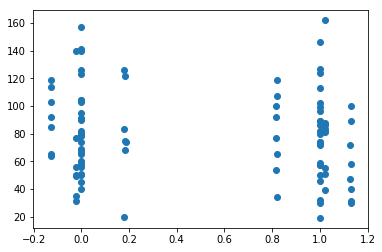

In [138]:
plt.scatter(design_matrix['active'], fmri_img.get_fdata()[30,13,23])

In [100]:
import sys
sys.path.append('/oak/stanford/groups/russpold/users/zenkavi/DevStudy_ServerScripts/utils')
from mni2vox import mni2vox

In [111]:
T = fmri_img.affine
mni2vox([0,-25,80],T)

(31, 23, 49)

In [108]:
z_map = fmri_glm.compute_contrast(conditions['active'],
                                  output_type='z_score')

Plot thresholded z scores map.

We display it on top of the average
functional image of the series (could be the anatomical image of the
subject).  We use arbitrarily a threshold of 3.0 in z-scale. We'll
see later how to use corrected thresholds.  we show to display 3
axial views: display_mode='z', cut_coords=3



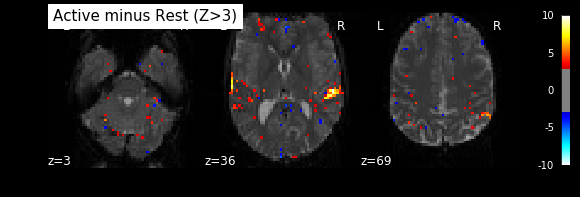

In [24]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

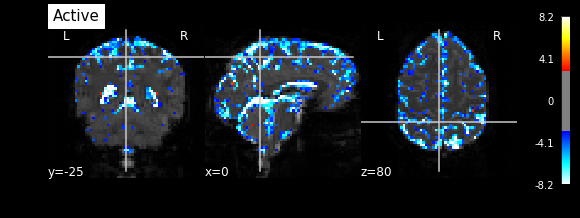

In [110]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,black_bg=True,
              title='Active')

Statistical signifiance testing. One should worry about the
statistical validity of the procedure: here we used an arbitrary
threshold of 3.0 but the threshold should provide some guarantees on
the risk of false detections (aka type-1 errors in statistics). One
first suggestion is to control the false positive rate (fpr) at a
certain level, e.g. 0.001: this means that there is.1% chance of
declaring active an inactive voxel.



Uncorrected p<0.001 threshold: 3.090


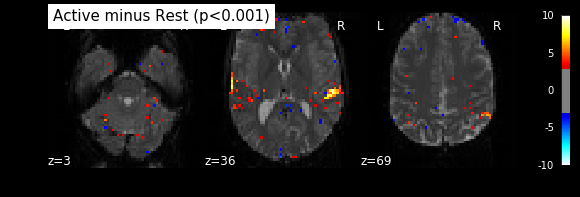

In [25]:
from nistats.thresholding import map_threshold
_, threshold = map_threshold(z_map, level=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.001)')
plt.show()

The problem is that with this you expect 0.001 * n_voxels to show up
while they're not active --- tens to hundreds of voxels. A more
conservative solution is to control the family wise errro rate,
i.e. the probability of making ony one false detection, say at
5%. For that we use the so-called Bonferroni correction



In [ ]:
_, threshold = map_threshold(z_map, level=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.05, corrected)')
plt.show()

This is quite conservative indeed !  A popular alternative is to
control the false discovery rate, i.e. the expected proportion of
false discoveries among detections. This is called the false
disovery rate



In [ ]:
_, threshold = map_threshold(z_map, level=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05)')
plt.show()

Finally people like to discard isolated voxels (aka "small
clusters") from these images. It is possible to generate a
thresholded map with small clusters removed by providing a
cluster_threshold argument. here clusters smaller than 10 voxels
will be discarded.



In [ ]:
clean_map, threshold = map_threshold(
    z_map, level=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05), clusters > 10 voxels')
plt.show()

We can save the effect and zscore maps to the disk



In [ ]:
z_map.to_filename(join(outdir, 'active_vs_rest_z_map.nii.gz'))
eff_map.to_filename(join(outdir, 'active_vs_rest_eff_map.nii.gz'))

Report the found positions in a table



In [ ]:
from nistats.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

the table can be saved for future use



In [ ]:
table.to_csv(join(outdir, 'table.csv'))

Performing an F-test

"active vs rest" is a typical t test: condition versus
baseline. Another popular type of test is an F test in which one
seeks whether a certain combination of conditions (possibly two-,
three- or higher-dimensional) explains a significant proportion of
the signal.  Here one might for instance test which voxels are well
explained by combination of the active and rest condition.



In [ ]:
import numpy as np
effects_of_interest = np.vstack((conditions['active'], conditions['rest']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

Specify the contrast and compute the correspoding map. Actually, the
contrast specification is done exactly the same way as for t
contrasts.



In [ ]:
z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')
plt.show()

Note that the statistic has been converted to a z-variable, which
makes it easier to represent it.



In [ ]:
clean_map, threshold = map_threshold(
    z_map, level=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Effects of interest (fdr=0.05), clusters > 10 voxels')
plt.show()

Oops, there is a lot of non-neural signal in there (ventricles, arteries)...

